## The Deep Ritz Method: implementation 

## (1) Solving the 1D Darcy’s Flow Problem with DeepRitz

Darcy’s law describes the flow of a fluid through a porous medium. In 1D, it is given by the steady-state equation:
$$
-\frac{d}{dx} \left( k(x) \frac{d p}{dx} \right) = f(x), \quad x \in [0,1]
$$
where:
- $p(x)$ is the pressure (unknown),
- $k(x)= (1 + \sin(\frac{3\pi}{2}x))/3$ is the permeability of the medium,
- $f(x)=\frac{3\pi^2}{4}(\cos(\frac{3\pi}{2}x)+\sin(3\pi x))$ is an external source term.

We impose Dirichlet boundary conditions:
$$
p(0) = 1, \quad p(1) = 0
$$
The corresponding **variational problem** is given as:
$$
\min_{u\in \mathcal{U}} I(u) =\int_{\Omega} \left(\frac{1}{2}k(x)|\nabla u(x)|^2-f(x)u(x)\right) ~ dx 
$$


### (1.1) Step 1: Approximating the Solution with a Neural Network

In [1]:
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
device = 'cpu'
#
class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Activation
        self.activation = nn.Tanh()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return x
#
model_u = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
from torchsummary import summary
summary(model_u, input_size=(1,), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]              80
              Tanh-2                   [-1, 40]               0
            Linear-3                   [-1, 40]           1,640
              Tanh-4                   [-1, 40]               0
            Linear-5                   [-1, 40]           1,640
              Tanh-6                   [-1, 40]               0
            Linear-7                   [-1, 40]           1,640
              Tanh-8                   [-1, 40]               0
            Linear-9                    [-1, 1]              41
Total params: 5,041
Trainable params: 5,041
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
-----------------------------------------------

### (1.2) Step 2: Obtain the training data (and testing data)

Size of boundary points: torch.Size([2, 1])
Size of integral points: torch.Size([10000, 1])
Size of testing points: torch.Size([1000, 1])


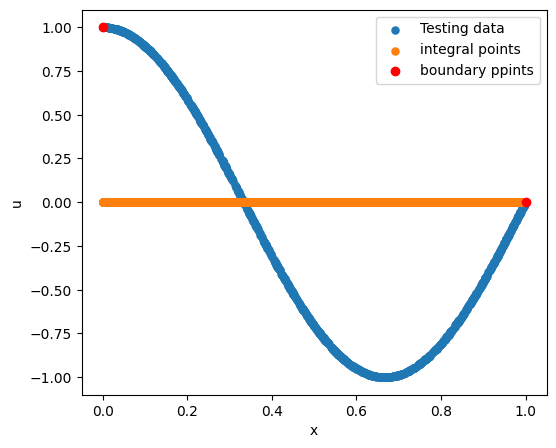

In [2]:
lb, ub = [0.], [1.]
n_int = 10000
dataType = torch.float32
np.random.seed(1234)
################################# The boundary points (x=0) and (x=1)
x_lb = np.array(lb)
x_rb = np.array(ub)
#
x_bd = np.vstack([x_lb, x_rb])
x_bd = torch.tensor(x_bd, dtype=dataType)
u_bd = torch.tensor([[1.], [0.]], dtype=dataType)
print('Size of boundary points:', x_bd.shape)
################################# The integral points (x)
x_int = np.random.uniform(lb, ub, n_int).reshape(-1,1)
x_int = torch.tensor(x_int, dtype=dataType)
print('Size of integral points:', x_int.shape)
################################# The testing dataset (x,u)
x_test = np.random.uniform(lb, ub, 1000).reshape(-1,1)
u_test = np.cos(3*np.pi*x_test/2)
x_test, u_test = torch.tensor(x_test, dtype=dataType),  torch.tensor(u_test, dtype=dataType)
print('Size of testing points:', x_test.shape)
#
plt.figure(figsize=(6,5))
plt.scatter(x_test, u_test, label='Testing data', linewidth=0.1)
plt.scatter(x_int, torch.zeros_like(x_int), label='integral points', linewidth=0.1)
plt.scatter(x_bd, u_bd, color='r', label='boundary ppints')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

### (1.3) Defining the loss function
The boundary condition loss:
$$
L_{bd} = \frac{1}{N_{bd}}\sum^{N_{bd}}_{i=1}|u_\theta(x_i)-u_{bd}(x_i)|^2.
$$

The PDE loss:
$$
L_{PDE}(\theta) = I[u_\theta] \approx \sum_{i=1}^{N_{int}} w_i \left( \frac{1}{2}k(x_i)|\nabla u_\theta(x_i)|^2 - f(x_i)u_\theta(x_i) \right).
$$

In [3]:
from torch.autograd import grad, Variable
#
torch.manual_seed(1234)

class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model 
        self.getLoss = torch.nn.MSELoss()
    
    def loss_bd(self, x_bd, u_bd):
        '''loss term related to boundary condition'''
        ############## Loss term related to the boundary condition
        x = x_bd.to(self.device)
        u = self.u_model(x)
        loss = self.getLoss(u, u_bd.to(self.device))
        
        return loss 
        
    def loss_pde(self, x_int=None):
        '''loss term related to the PDE'''
        ################################# The integral points
        if x_int is None:
            x_int = np.random.uniform(lb, ub, n_int).reshape(-1,1)
            x_int = torch.tensor(x_int, dtype=dataType)
        ################# The PDE loss
        x = Variable(x_int, requires_grad=True).to(self.device)
        #
        u = self.u_model(x)
        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        kx = (1 + torch.sin(torch.pi*3*x/2))/3
        fx = 3*torch.pi**2/4 * (torch.cos(3*torch.pi*x/2) + torch.sin(3*torch.pi * x))
        # The energy
        energy = torch.mean(0.5 * kx * du_dx**2 - fx*u)
        
        return energy

    def get_error(self, x_test, u_test):
        '''Compute the L^2 relative error when testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)
        
        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))

############ Training setups
from tqdm import trange
#
epochs = 5000
lr = 1e-3
model_u = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/5), gamma=0.5)
#
w_pde = 2.
w_bd = 10.
############ The training process
error_list = []
for epoch in trange(epochs):
    lossClass = LossClass(model_u)
    ############# Calculate losses
    loss_bd = lossClass.loss_bd(x_bd, u_bd)
    loss_in = lossClass.loss_pde(x_int=None)
    loss_train = w_pde*loss_in + w_bd*loss_bd
    #
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    #
    with torch.no_grad():
        error = lossClass.get_error(x_test, u_test)
        error_list.append(error.item())
    #
    scheduler.step()  # Adjust learning rate
    if (epoch+1)%500==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
        print(error_list.pop())

 10%|████                                    | 510/5000 [00:08<01:14, 60.38it/s]

Epoch:499, The loss is:-4.618037700653076, lr: 0.001
0.01247858814895153


 20%|███████▉                               | 1011/5000 [00:17<01:09, 57.44it/s]

Epoch:999, The loss is:-4.801083087921143, lr: 0.0005
0.03800637647509575


 30%|███████████▊                           | 1510/5000 [00:27<01:01, 56.75it/s]

Epoch:1499, The loss is:-4.678225994110107, lr: 0.0005
0.021537454798817635


 40%|███████████████▋                       | 2007/5000 [00:36<00:51, 58.41it/s]

Epoch:1999, The loss is:-4.722440242767334, lr: 0.00025
0.01531224511563778


 50%|███████████████████▌                   | 2508/5000 [00:45<00:48, 50.86it/s]

Epoch:2499, The loss is:-4.881506443023682, lr: 0.00025
0.04621889814734459


 60%|███████████████████████▍               | 3007/5000 [00:54<00:44, 44.40it/s]

Epoch:2999, The loss is:-4.892425537109375, lr: 0.000125
0.03068108670413494


 70%|███████████████████████████▎           | 3507/5000 [01:03<00:27, 54.00it/s]

Epoch:3499, The loss is:-4.6470255851745605, lr: 0.000125
0.002736245281994343


 80%|███████████████████████████████▎       | 4010/5000 [01:12<00:15, 62.10it/s]

Epoch:3999, The loss is:-4.7152934074401855, lr: 6.25e-05
0.023068031296133995


 90%|███████████████████████████████████▏   | 4511/5000 [01:20<00:08, 58.84it/s]

Epoch:4499, The loss is:-4.949991226196289, lr: 6.25e-05
0.01174193900078535


100%|███████████████████████████████████████| 5000/5000 [01:29<00:00, 55.95it/s]

Epoch:4999, The loss is:-4.613578796386719, lr: 3.125e-05
0.025721892714500427


### (1.4) make prediction with the trained model


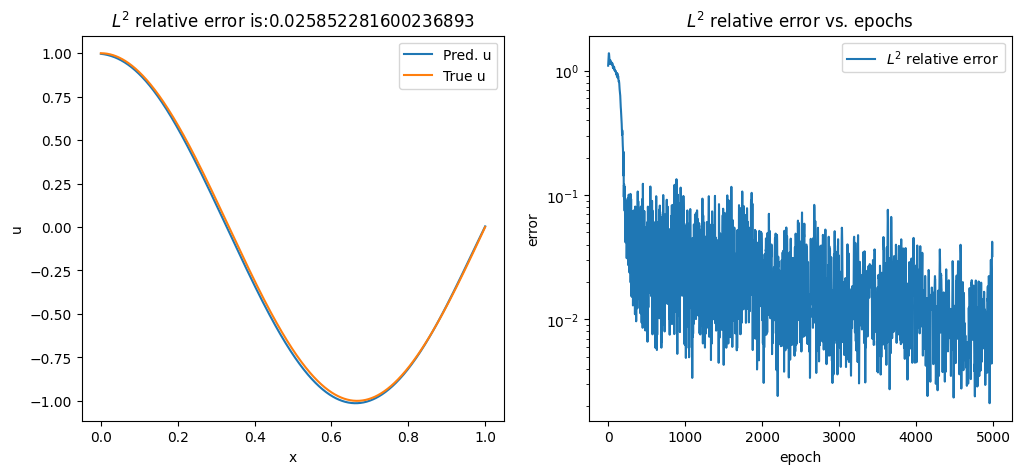

In [4]:
x_query = np.linspace(lb, ub, 1000)
x_query = torch.tensor(x_query, dtype=dataType)
#
u_true = torch.cos(torch.pi*3*x_query/2)
u_query = model_u(x_query.to(device)).detach().cpu()
error = torch.sqrt(torch.sum((u_true-u_query)**2)/torch.sum(u_true**2))
#
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].plot(x_query, u_query, label='Pred. u')
axes[0].plot(x_query, u_true, label='True u')
axes[0].set_title(f'$L^2$ relative error is:{error}')
axes[0].set_xlabel('x')
axes[0].set_ylabel('u')
axes[0].legend()
#
axes[1].semilogy(error_list, label='$L^2$ relative error')
axes[1].set_title('$L^2$ relative error vs. epochs')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('error')
axes[1].legend()
#
plt.show()

## (2) Solving the 2d Poisson Equation using DeepRitz

The Poisson equation models steady-state problems in physics, such as electrostatics and heat conduction:
$$
-\nabla^2 u = - \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right) = f(x, y), \quad (x,y) \in \Omega=[-1,1]^2
$$
where $f(x,y)=2\pi^2\sin(\pi x)\sin(\pi y)$ and Dirichlet boundary condition is considered:
$$
u(x,y) = 0, \quad (x,y) \in \partial \Omega
$$
The corresponding **variational problem** is given as:
$$
\min_{u\in \mathcal{U}} I(u) =\int_{\Omega} \left(\frac{1}{2}|\nabla u(x)|^2-f(x)u(x)\right) ~ dx 
$$

### (2.1) Parametrizing the solution with network models

In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import torch.nn as nn
device = 'cpu'
#
class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Activation
        self.activation = nn.Tanh()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return x
#
model_u = MLP([2, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
from torchsummary import summary
summary(model_u, input_size=(2,), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]             120
              Tanh-2                   [-1, 40]               0
            Linear-3                   [-1, 40]           1,640
              Tanh-4                   [-1, 40]               0
            Linear-5                   [-1, 40]           1,640
              Tanh-6                   [-1, 40]               0
            Linear-7                   [-1, 40]           1,640
              Tanh-8                   [-1, 40]               0
            Linear-9                    [-1, 1]              41
Total params: 5,081
Trainable params: 5,081
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
-----------------------------------------------

### (2.2) Step 2: Obtain the training data (and testing data)

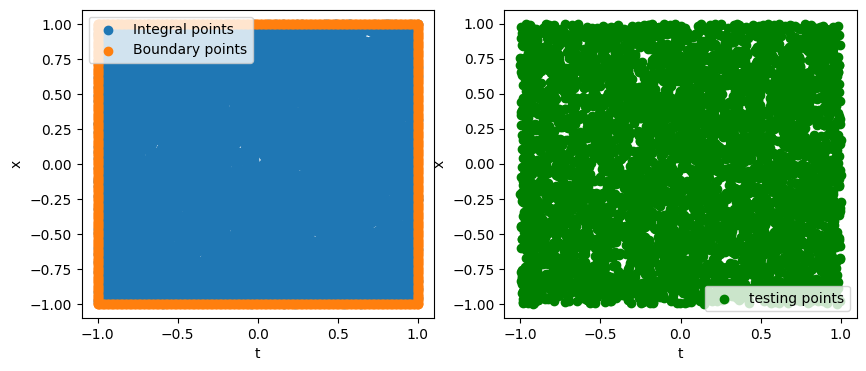

In [3]:
lb, ub = np.array([-1., -1.]), np.array([1, 1.])
#
n_int = 10000
n_bd_each_side = 250
dataType = torch.float32
np.random.seed(1234)
###### The truth solution: for generating the testing dataset, the initial condition, and the boundary condition
def u_true(x):
    '''The ground truth solution'''
    x1, x2 = x[...,0:1], x[...,1:2]
    #
    u = torch.sin(torch.pi*x1)*torch.sin(torch.pi*x2)
    
    return u
    
################################# The collocation points (x,t)
x_int = np.random.uniform(lb, ub, (n_int,2))
x_int = torch.tensor(x_int, dtype=dataType)

# ################################# The boundary points
# The upper and lower boundaries
x_lw = np.vstack((np.linspace(lb[0], ub[0], n_bd_each_side), lb[0]*np.ones(n_bd_each_side))).T
x_up = np.vstack((np.linspace(lb[0], ub[0], n_bd_each_side), ub[0]*np.ones(n_bd_each_side))).T
# The left and right boundaries
x_lt = np.vstack((lb[1]*np.ones(n_bd_each_side), np.linspace(lb[1], ub[1], n_bd_each_side))).T
x_rt = np.vstack((ub[1]*np.ones(n_bd_each_side), np.linspace(lb[1], ub[1], n_bd_each_side))).T
# the boundary condition
x_bd = np.concatenate([x_lw, x_up, x_lt, x_rt], axis=0)
x_bd = torch.tensor(x_bd, dtype=dataType)
u_bd = torch.zeros_like(x_bd[:,0:1])

# ################################# The testing dataset
x_test = np.random.uniform(lb, ub, (5000, 2))
# testing dataset
x_test = torch.tensor(x_test, dtype=dataType)
u_test = u_true(x_test)

# ##################################
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].scatter(x_int[...,0], x_int[...,1], label='Integral points')
axes[0].scatter(x_bd[:,0], x_bd[:,1], label='Boundary points')
axes[0].set_xlabel('t')
axes[0].set_ylabel('x')
axes[0].legend()
#
axes[1].scatter(x_test[:,0], x_test[:,1], color='g', label='testing points')
axes[1].set_xlabel('t')
axes[1].set_ylabel('x')
axes[1].legend()
plt.show()

### (2.3) Defining the loss function
The boundary condition loss:
$$
L_{bd} = \frac{1}{N_{bd}}\sum^{N_{bd}}_{i=1}|u_\theta(x_i)|^2.
$$

The PDE loss:
$$
L_{PDE}(\theta) = I[u_\theta] \approx \sum_{i=1}^{N_{int}} w_i \left( \frac{1}{2} |\nabla u_\theta(x_i)|^2 - f(x_i)u_\theta(x_i) \right).
$$

In [5]:
from torch.autograd import grad, Variable
#
torch.manual_seed(1234)

class Mollifier(object):
    '''For capturing the zero boundary condition'''

    def __init__(self, dim):
        self.dim = dim

    def apply(self, u, x):
        ''' '''
        for d in range(self.dim):
            u = u*torch.cos(torch.pi/2*x[...,d:d+1])
        return u

class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model 
        self.getLoss = torch.nn.MSELoss()
        #
        self.mollifier = Mollifier(2)
        
    def loss_pde(self, x_int=None):
        '''loss term related to the PDE'''
        ################################# The integral points
        if x_int is None:
            x_int = np.random.uniform(lb, ub, (n_int,2))
            x_int = torch.tensor(x_int, dtype=dataType)
        ################# The PDE loss
        x = Variable(x_int, requires_grad=True).to(self.device)
        #
        u = self.u_model(x)
        u = self.mollifier.apply(u, x)
        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        fx = 2 * torch.pi**2 * torch.sin(torch.pi*x[:,0:1])*torch.sin(torch.pi*x[:,1:2])
        # The energy
        energy = torch.mean(0.5 * torch.sum(du_dx**2, dim=1, keepdim=True) - fx*u)

        return energy

    def get_error(self, x_test, u_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)
        u = self.mollifier.apply(u, x_test)
        
        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))

############ Training setups
from tqdm import trange
#
epochs = 5000
lr = 1e-3
model_u = MLP([2, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
#
w_pde = 2.
w_bd = 10.
############ The training process
error_list = []
for epoch in trange(epochs):
    lossClass = LossClass(model_u)
    ############# Calculate losses
    loss_train = lossClass.loss_pde(x_int=None)
    #
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    #
    with torch.no_grad():
        error = lossClass.get_error(x_test, u_test)
        error_list.append(error.item())
    scheduler.step()  # Adjust learning rate
    #
    if (epoch+1)%500==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
        print(error_list.pop())

 10%|████                                    | 510/5000 [00:09<01:22, 54.36it/s]

Epoch:499, The loss is:-2.408792018890381, lr: 0.001
0.10742539912462234


 20%|███████▉                               | 1010/5000 [00:19<01:15, 53.17it/s]

Epoch:999, The loss is:-2.502847194671631, lr: 0.001
0.13415467739105225


 30%|███████████▋                           | 1506/5000 [00:29<01:12, 48.23it/s]

Epoch:1499, The loss is:-2.502443313598633, lr: 0.0005
0.02984633482992649


 40%|███████████████▋                       | 2010/5000 [00:39<00:55, 53.91it/s]

Epoch:1999, The loss is:-2.4416871070861816, lr: 0.0005
0.03935643658041954


 50%|███████████████████▌                   | 2510/5000 [00:49<00:47, 52.68it/s]

Epoch:2499, The loss is:-2.438643455505371, lr: 0.00025
0.021061928942799568


 60%|███████████████████████▍               | 3005/5000 [00:59<00:42, 47.32it/s]

Epoch:2999, The loss is:-2.4593677520751953, lr: 0.00025
0.03861738741397858


 70%|███████████████████████████▎           | 3507/5000 [01:11<00:30, 48.93it/s]

Epoch:3499, The loss is:-2.4321694374084473, lr: 0.00025
0.02196626551449299


 80%|███████████████████████████████▎       | 4009/5000 [01:21<00:20, 48.86it/s]

Epoch:3999, The loss is:-2.4492549896240234, lr: 0.000125
0.04551238566637039


 90%|███████████████████████████████████▏   | 4509/5000 [01:31<00:10, 49.07it/s]

Epoch:4499, The loss is:-2.4970972537994385, lr: 0.000125
0.018130257725715637


100%|███████████████████████████████████████| 5000/5000 [01:40<00:00, 49.55it/s]

Epoch:4999, The loss is:-2.569216012954712, lr: 6.25e-05
0.021851370111107826


### (2.4) make prediction with trained model

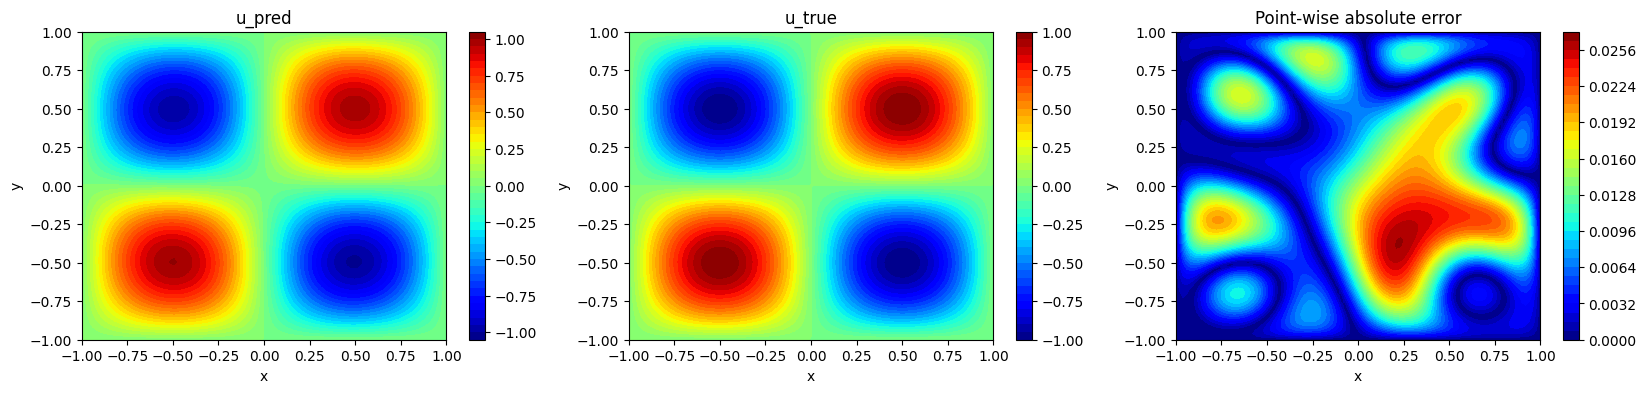

In [7]:
from scipy.interpolate import griddata

####### Make prediction with the trained model
# The grids (x,t)
x1_grid = np.linspace(lb[0], ub[0], 100)
x2_grid = np.linspace(lb[1], ub[1], 100)
x_mesh = np.meshgrid(x1_grid, x2_grid)
x_query= np.vstack((x_mesh[0].flatten(), x_mesh[1].flatten())).T
x_query = torch.tensor(x_query, dtype=dataType)
# The prediction
u_query = model_u(x_query.to(device)).detach()
u_query = Mollifier(2).apply(u_query, x_query)
u_ref = u_true(x_query)

####### Visualize the solution
mesh = np.meshgrid(np.linspace(lb[0], ub[0], 100), np.linspace(lb[1], ub[1], 100))
x1_plot, x2_plot = mesh[0], mesh[1]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
#
z_plot = griddata((x_query[:,0], x_query[:,1]), np.ravel(u_query), (x1_plot, x2_plot), method='cubic')
cntr = axs.flat[:][0].contourf(x1_plot, x2_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][0])
axs.flat[:][0].set_title('u_pred')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
z_plot = griddata((x_query[:,0], x_query[:,1]), np.ravel(u_ref), (x1_plot, x2_plot), method='cubic')
cntr = axs.flat[:][1].contourf(x1_plot, x2_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][1])
axs.flat[:][1].set_title('u_true')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
z_plot = griddata((x_query[:,0], x_query[:,1]), np.abs(np.ravel(u_ref)-np.ravel(u_query)), (x1_plot, x2_plot), method='cubic')
cntr = axs.flat[:][2].contourf(x1_plot, x2_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][2])
axs.flat[:][2].set_title('Point-wise absolute error')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('y')
#
plt.show()

### <font color='red'>Question: why does the oscillation occur?</font>

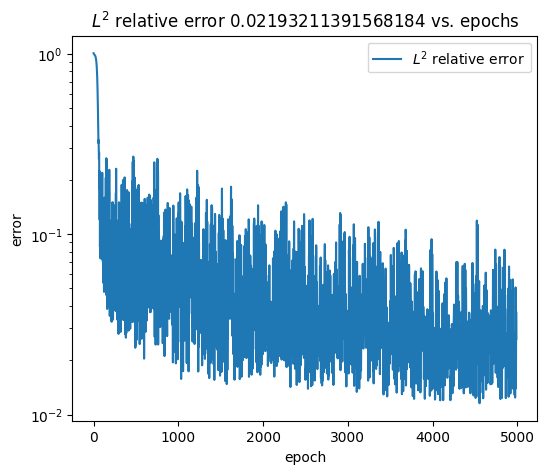

In [8]:
error = torch.sqrt(torch.sum((u_ref-u_query)**2)/torch.sum(u_ref**2))
#
plt.figure(figsize=(6,5))
plt.semilogy(error_list, label='$L^2$ relative error')
plt.title(f'$L^2$ relative error {error} vs. epochs')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()
#
plt.show()

## (3) Exercise
### Task1: Improving the DeepRitz method in solving the 1D Darcy’s Flow Problem with more accurate integral approximation method

Darcy’s law describes the flow of a fluid through a porous medium. In 1D, it is given by the steady-state equation:
$$
-\frac{d}{dx} \left( k(x) \frac{d p}{dx} \right) = f(x), \quad x \in [0,1]
$$
where:
- $p(x)$ is the pressure (unknown),
- $k(x)= (1 + \sin(\frac{3\pi}{2}x))/3$ is the permeability of the medium,
- $f(x)=\frac{3\pi^2}{4}(\cos(\frac{3\pi}{2}x)+\sin(3\pi x))$ is an external source term.

We impose Dirichlet boundary conditions:
$$
p(0) = 1, \quad p(1) = 0
$$
The corresponding **variational problem** is given as:
$$
\min_{u\in \mathcal{U}} I(u) =\int_{\Omega} \left(\frac{1}{2}k(x)|\nabla u(x)|^2-f(x)u(x)\right) ~ dx 
$$

**Hint:** Approximate the integral in the variational form with the [**Gaussian quadrature rule**](https://en.wikipedia.org/wiki/Gaussian_quadrature).

In [3]:
import numpy as np
import scipy.integrate

x_int, w_int = np.polynomial.legendre.leggauss(5)
print(x_int)
print(w_int)

[-0.90617985 -0.53846931  0.          0.53846931  0.90617985]
[0.23692689 0.47862867 0.56888889 0.47862867 0.23692689]


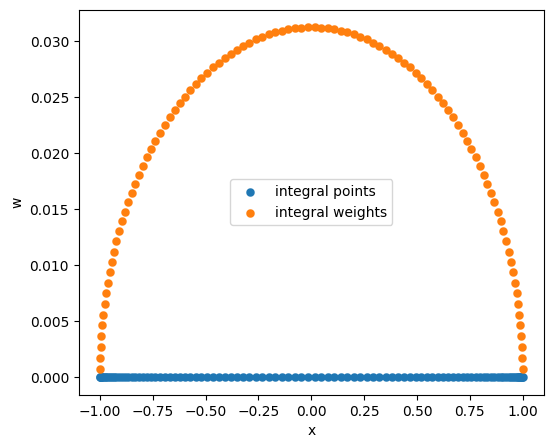

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#
x_int, w_int = np.polynomial.legendre.leggauss(100)
#
plt.figure(figsize=(6,5))
plt.scatter(x_int, np.zeros(x_int.shape), label='integral points', linewidth=0.1)
plt.scatter(x_int, w_int, label='integral weights', linewidth=0.1)
plt.xlabel('x')
plt.ylabel('w')
plt.legend()
plt.show()

### Task2: Solving the 5d Poisson Equation using PINN
Now, let's consider a 5D Poisson equation with the following form:
$$
\begin{split}
-\Delta u &= f,\quad x\in\Omega=[-1,1]^{5} \\
u &= 0,\quad x\in\partial\Omega
\end{split}
$$
where $f(x)=5\lambda^2\pi^2\prod^{5}_{i=1}\sin(\lambda\pi x_i)$ and $\lambda=1$. The corresponding **variational problem** is given as:
$$
\min_{u\in \mathcal{U}} I(u) =\int_{\Omega} \left(\frac{1}{2}|\nabla u(x)|^2-f(x)u(x)\right) ~ dx 
$$